In [432]:
%connect_info

{"key":"3a477f93-eed6-4444-9139-e47508b43448","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9005,"control_port":9006,"shell_port":9007,"stdin_port":9013,"iopub_port":9014,"kernel_name":"python3112jvsc74a57bd04149aa2f31a7f8b5ff184e82bf464dce73529b69401cc2940ad6232b832b4da8"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v3317740084bded2cd40eb3f041645a1207c3cd659.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [433]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fft
from copy import deepcopy


In [434]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import pywt
import pycwt

from hypyp.fnirs_tools import (
    xwt_coherence_morl,
)
from hypyp.fnirs_tools_orig import (
    xwt_coherence_morl_orig,
)
import hypyp.plots
from hypyp.plots import (
    plot_spectrogram_periods,
    spectrogram_plot_period,
)

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


## Sine waves

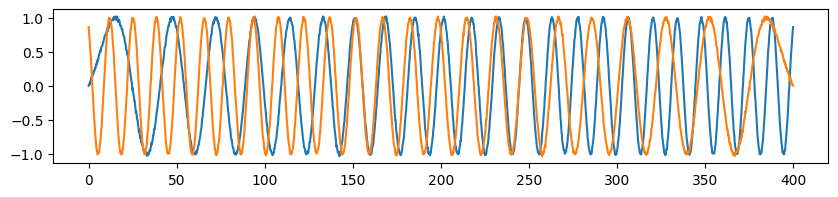

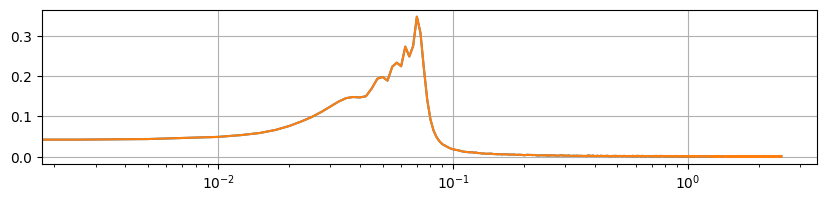

In [435]:
plt.figure(figsize=(10,2))

fs = 5
N = 2000
T = 1.0 / fs
x = np.linspace(0, N/fs, N)
#x = np.linspace(0, 2, 2000)

signal_choice = 'chirp'

if signal_choice == 'sinusoid':
    freq1 = 0.02
    freq2 = 0.04
    y1 = np.sin(x * 2 * np.pi * freq1)
    y2 = np.sin(x * 2 * np.pi * freq2)
elif signal_choice == 'sinusoid_similar':
    freq1 = 0.02
    freq2 = freq1 - 0.0001
    y1 = np.sin(x * 2 * np.pi * freq1)
    y2 = np.sin(x * 2 * np.pi * freq2)
elif signal_choice == 'sinusoid_same':
    freq1 = 0.02
    freq2 = freq1
    y1 = np.sin(x * 2 * np.pi * freq1)
    y2 = np.sin(x * 2 * np.pi * freq2)
elif signal_choice == 'dual':
    freq1 = 0.02
    freq2 = 0.04
    y1 = np.cos(2*np.pi*freq1*x) * (x>=0.5).astype(int) * (x<1.1).astype(int) + np.cos(2*np.pi*freq2*x) * (x>= 0.2).astype(int) * (x<1.4).astype(int)
    y2 = np.sin(2*np.pi*freq1*x) * (x>=0.6).astype(int) * (x<1.2).astype(int) + np.sin(2*np.pi*freq2*x) * (x>= 0.4).astype(int) * (x<1.6).astype(int)
elif signal_choice == 'chirp':
    def make_chirp(t, t0, base_freq):
        frequencies = (base_freq * np.log(t + t0)) ** 2
        chirp = np.sin(2 * np.pi * frequencies * t)
        return chirp, frequencies
    y1, chirp_frequencies = make_chirp(x, 10, 0.04)
    y2 = np.flip(y1)
else:
    raise 'Unknown signal choice'

noise_level = 0.01
#noise_level = 0

y1 +=  noise_level * np.random.normal(0, 1, len(x))
y2 +=  noise_level * np.random.normal(0, 1, len(x))

plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

plt.figure(figsize=(10,2))
# sample spacing
yf = fft.fft(y1)
xf = fft.fftfreq(N, T)[:N//2]
yf2 = fft.fft(y2)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.plot(xf, 2.0/N * np.abs(yf2[0:N//2]))
plt.xscale('log')
plt.grid()
plt.show()

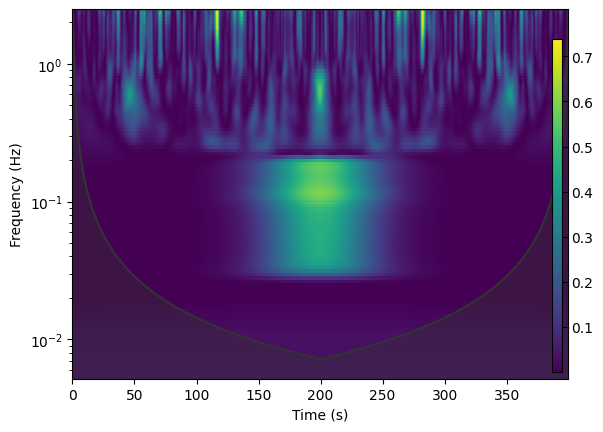

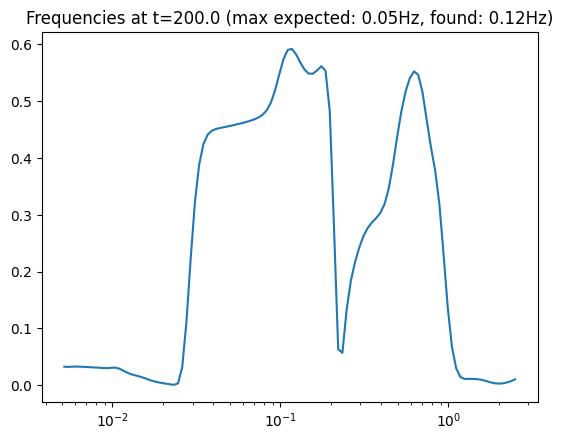

In [436]:
tracer = dict(name='pywt')
wct_pywt, times, freqs_pywt, coif_pywt = xwt_coherence_morl(
    y1,
    y2,
    wavelet_name='cmor2-1.0',
    dt=T,
    normalize=True,
    smoothing_params=dict(smooth_factor=-0.1, boxcar_size=1),
)

hypyp.plots.plot_wavelet_coherence(np.abs(wct_pywt), times, freqs_pywt, coif_pywt)
plt.show()

col_mid = len(times)//2
plt.plot(freqs_pywt, wct_pywt[:,col_mid])
plt.title(f'Frequencies at t={times[col_mid]} (max expected: {chirp_frequencies[col_mid]:.2f}Hz, found: {freqs_pywt[np.argmax(wct_pywt[:,col_mid])]:.2f}Hz)')
plt.xscale('log')
plt.show()
#
#xx,yy = np.meshgrid(times, freqs_pywt)
#plt.pcolor(xx, yy, np.abs(wct_pywt))
#plt.yscale('log')
#plt.ylabel('frequency')
#plt.xlabel('time')
#plt.show()


<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

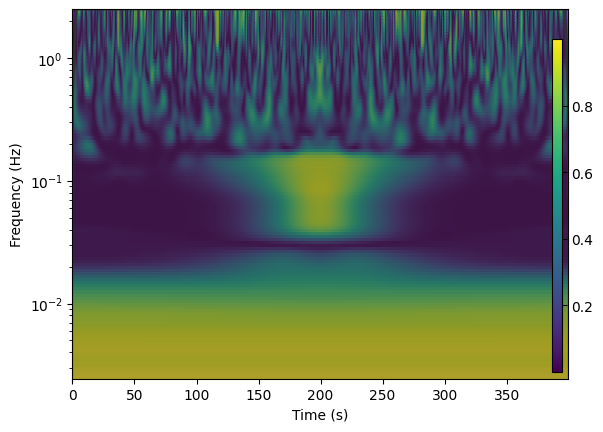

In [437]:
wct_pycwt, aWCT_pycwt, coif_pycwt, freqs_pycwt, sig = pycwt.wct(y1, y2, dt=T, sig=False)

hypyp.plots.plot_wavelet_coherence(np.abs(wct_pycwt), times, freqs_pycwt, coif_pycwt)

#xx,yy = np.meshgrid(times, freqs_pycwt)
#plt.pcolor(xx, yy, np.abs(wct_pycwt))
#plt.yscale('log')
#plt.ylabel('frequency')
#plt.xlabel('time')
#plt.show()